#Download & Move data to correct location

In [ ]:
!pip install -q open_clip_torch
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q transformers
!pip install -q opendatasets
!pip install -q pandas
!pip install -q rouge-metric
!pip install -q pycocoevalcap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 8.2 MB/s eta 0:00:00


In [ ]:
import os
import opendatasets as od
import shutil
import torch
import torch.nn as nn
import open_clip
import clip
import pickle
import pandas as pd
import numpy as np
import json
import sys
from PIL import Image
from tqdm import tqdm, trange
from torch.nn import functional as nnf
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from enum import Enum
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
from typing import Tuple, Optional, Union, List
from google.colab import files
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

In [ ]:
#@title Global functions
def get_device():
    if not torch.cuda.is_available():
        return torch.device('cpu')
    device_id = torch.cuda.device_count() - 1
    return torch.device(f'cuda:{device_id}')

# Open clip
def OpenCLIP(model_name: str = 'ViT-L-14', pretrained: str = 'openai'):
  clip_model, _, preprocess = open_clip.create_model_and_transforms(model_name=model_name, pretrained=pretrained, device=get_device())
  class Model: # change the encode_image() content but keep the syntax for easy use
    def __init__(self, clip_model):
        self.clip_model = clip_model

    def encode_image(self, image):
        feature = self.clip_model.encode_image(image)
        feature /= feature.norm(dim=-1, keepdim=True)
        return feature
  return Model(clip_model), preprocess

# Normal clip
def CloseCLIP(name : str = 'ViT-L/14'):
  clip_model, preprocess = clip.load(name=name, device=get_device())
  return clip_model, preprocess

In [ ]:
#@title Global parameters

# In original Clipcap, all False
dataset_name = 'Flickr8K' # @param ["Flickr30K", "Flickr8K"]
isOpenCLIP= True
isCustomTokenizer = False #@param {type:'boolean'}
isGradientClipping = False #@param {type:'boolean'}

In [ ]:
if dataset_name == 'Flickr30K':
  od.download("https://www.kaggle.com/datasets/eeshawn/flickr30k")
elif dataset_name == 'Flickr8K':
  od.download("https://www.kaggle.com/datasets/adityajn105/flickr8k")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: triethuynhminh
Your Kaggle Key: ··········


100%|██████████| 4.08G/4.08G [00:47<00:00, 91.9MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# cd to the project folder, remember to create the folder before this
full_path = '/content/gdrive/My Drive/CLIP/' + dataset_name
if isOpenCLIP:
  full_path += '/OpenCLIP'
  pass
else:
  full_path += '/NormalClip'
  pass

if isGradientClipping:
  full_path += '/Gradient'
else:
  if isCustomTokenizer:
    full_path += '/CustomTokenizer'

os.chdir(full_path)
full_path

'/content/gdrive/My Drive/CLIP/Flickr8K/Open_CLIP'

#Step 1
###Dataset Embedding

In [ ]:
# Embedd all image features to img_embedding_train.pkl and img_embedding_test.pkl
def ClipEmbedding():
    out_path_train = f"{full_path}/img_embedding_train.pkl"
    out_path_test = f"{full_path}/img_embedding_test.pkl"
    clip_model, preprocess = OpenCLIP() if isOpenCLIP else CloseCLIP()

    if dataset_name == 'Flickr30K':
        data = pd.read_csv('/content/flickr30k/captions.txt', delimiter=",")
        data = data.rename(columns={'image_name': 'image', 'comment': 'caption'})[['image','caption']]
    elif dataset_name == 'Flickr8K':
        data = pd.read_csv('/content/flickr8k/captions.txt', delimiter=",")

    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption_number'] = data.index % 5
    data = data.to_dict(orient='records')

    data_train = data[:-5000]
    data_test = data[-5000:] # Last 1000 images (5000 captions) for testing

    def get_embedding(data, out_path):
      device = get_device()
      print("%0d captions loaded from json " % len(data))
      all_embeddings = []
      all_captions = []

      current_prefix = 0
      for i in tqdm(range(len(data))):
          d = data[i]
          img_id = d["image"]
          if dataset_name == 'Flickr30K':
            filename = "/content/flickr30k/flickr30k_images/%s" % img_id
          elif dataset_name == 'Flickr8K':
            filename = "/content/flickr8k/Images/%s" % img_id

          # only process first of 5 identical images
          if d['caption_number'] == 0:
            # Extract features
            image = preprocess(Image.open(filename)).unsqueeze(0).to(device)
            with torch.no_grad(), torch.cuda.amp.autocast():
                prefix = clip_model.encode_image(image)
            current_prefix = prefix
          else:
            prefix = current_prefix

          # Save the index of every picture, original code did so, idk why
          d["clip_embedding"] = i

          all_embeddings.append(prefix)
          all_captions.append(d)
          # Checkpoint once every 10000 captions, just in case
          if (i + 1) % 10000 == 0:
              with open(out_path, 'wb') as f:
                  pickle.dump({"clip_embedding": torch.cat(all_embeddings, dim=0), "caption": all_captions}, f)

      with open(out_path, 'wb') as f:
          pickle.dump({"clip_embedding": torch.cat(all_embeddings, dim=0), "caption": all_captions}, f)

      print('Done')
      print("%0d embeddings saved " % len(all_embeddings))

    get_embedding(data_train, out_path_train)
    get_embedding(data_test, out_path_test)


if __name__ == '__main__':
    ClipEmbedding()


#Step 2
###Custom tokenizer

In [ ]:
with open('img_embedding_train.pkl', 'rb') as f:
    tokenizer_data = pickle.load(f)

# Convert your data to a Hugging Face Dataset
tokenizer_data = pd.DataFrame(tokenizer_data['caption'])

In [ ]:
# make generator, for memory efficiency
def get_training_corpus():
    return (
        tokenizer_data[i : i + 1000]['caption']
        for i in range(0, len(tokenizer_data), 1000)
    )

In [ ]:
training_corpus = get_training_corpus()

In [ ]:
old_tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer = old_tokenizer.train_new_from_iterator(training_corpus, old_tokenizer.vocab_size)

In [ ]:
tokenizer.save_pretrained('new_tokenizer')

OSError: ignored

#Step 3
###Train

In [ ]:
class ClipFlickrDataset(Dataset):

    def __len__(self) -> int:
        return len(self.captions_tokens)

    def pad_tokens(self, item: int):
        tokens = self.captions_tokens[item]
        padding = self.max_seq_len - tokens.shape[0]
        if padding > 0:
            tokens = torch.cat((tokens, torch.zeros(padding, dtype=torch.int64) - 1))
            self.captions_tokens[item] = tokens
        elif padding < 0:
            tokens = tokens[:self.max_seq_len]
            self.captions_tokens[item] = tokens
        mask = tokens.ge(0)  # mask is zero where we out of sequence
        tokens[~mask] = 0
        mask = mask.float()
        mask = torch.cat((torch.ones(self.prefix_length), mask), dim=0)  # adding prefix mask
        return tokens, mask

    def __getitem__(self, item: int) -> Tuple[torch.Tensor, ...]:
        tokens, mask = self.pad_tokens(item)
        prefix = self.prefixes[self.caption2embedding[item]]
        if self.normalize_prefix:
            prefix = prefix.float()
            prefix = prefix / prefix.norm(2, -1)
        return tokens, mask, prefix

    def __init__(self, data_path: str,  prefix_length: int, tokenizer_type: str = "gpt2",
                 normalize_prefix=False):
        self.tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_type)
        self.prefix_length = prefix_length
        self.normalize_prefix = normalize_prefix
        with open(data_path, 'rb') as f:
            all_data = pickle.load(f)
        print("Data size is %0d" % len(all_data["clip_embedding"]))
        sys.stdout.flush()
        self.prefixes = all_data["clip_embedding"]
        captions_raw = all_data["caption"]
        self.image_ids = [caption["image"] for caption in captions_raw]
        self.captions = [caption['caption'] for caption in captions_raw]
        if os.path.isfile(f"{data_path[:-4]}_tokens.pkl"):
            with open(f"{data_path[:-4]}_tokens.pkl", 'rb') as f:
                self.captions_tokens, self.caption2embedding, self.max_seq_len = pickle.load(f)
        else:
            self.captions_tokens = []
            self.caption2embedding = []
            max_seq_len = 0
            for caption in captions_raw:
                self.captions_tokens.append(torch.tensor(self.tokenizer.encode(caption['caption']), dtype=torch.int64))
                self.caption2embedding.append(caption["clip_embedding"])
                max_seq_len = max(max_seq_len, self.captions_tokens[-1].shape[0])
            # self.max_seq_len = max_seq_len
            with open(f"{data_path[:-4]}_tokens.pkl", 'wb') as f:
                pickle.dump([self.captions_tokens, self.caption2embedding, max_seq_len], f)
        all_len = torch.tensor([len(self.captions_tokens[i]) for i in range(len(self))]).float()
        self.max_seq_len = min(int(all_len.mean() + all_len.std() * 10), int(all_len.max()))


class MLP(nn.Module):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)

class ClipCaptionModel(nn.Module):

    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, mask: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)

        if labels is None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, clip_length: Optional[int] = None, prefix_size: int = 768,
                 num_layers: int = 8, tokenizer_type: str = 'gpt2'):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt.resize_token_embeddings(len(GPT2Tokenizer.from_pretrained(tokenizer_type))) # resize model's vocab embedding
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2,
                                     self.gpt_embedding_size * prefix_length))


def load_model(args, epoch_or_latest: Union[str, int] = '_latest'):

    if type(epoch_or_latest) is int:
        epoch_or_latest = f"-{epoch_or_latest:03d}"
    model_path = os.path.join(args.out_dir, f"{args.prefix}{epoch_or_latest}.pt")
    model = ClipCaptionModel(args.prefix_length)
    if os.path.isfile(model_path):
        print(f"loading model from {model_path}")
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    else:
        print(f"{model_path} is not exist")
    return model


def train(dataset: ClipFlickrDataset, model: ClipCaptionModel, args,
          lr :float = 2e-5, warmup_steps:int = 100, output_dir: str = ".", output_prefix: str = "", current_epoch: int = 0):

    device = get_device()
    batch_size = args.batch_size
    epochs = args.epochs
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    model = model.to(device)
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=epochs * len(train_dataloader)
    )
    prev_loss = float('inf')  # Khởi tạo loss trước đó là vô cùng lớn
    num_epochs_without_improvement = 0  # Số epoch không cải thiện loss
    max_epochs_without_improvement = 3  # Số epoch tối đa cho phép không cải thiện

    for epoch in range(current_epoch + 1, epochs):
        print(f">>> Training epoch {epoch}")
        sys.stdout.flush()
        progress = tqdm(total=len(train_dataloader), desc=output_prefix)
        for idx, (tokens, mask, prefix) in enumerate(train_dataloader):
            model.zero_grad()
            tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.float32)
            outputs = model(tokens, prefix, mask)
            logits = outputs.logits[:, dataset.prefix_length - 1: -1]
            loss = nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=0)
            loss.backward()
            if isGradientClipping:
              clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            progress.set_postfix({"loss": loss.item()})
            progress.update()

        progress.close()

        if loss < prev_loss:
            prev_loss = loss
            num_epochs_without_improvement = 0
        else:
            num_epochs_without_improvement += 1

        if num_epochs_without_improvement >= max_epochs_without_improvement:
            print(f"Stopping training due to lack of improvement for {max_epochs_without_improvement} epochs.")
            break

        if epoch % args.save_every == 0 or epoch == epochs - 1:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{epoch:03d}.pt"),
            )
    return model

# Parser object
class ParserObject:
    def __init__(self):
        self.data = 'img_embedding_train.pkl'
        self.tokenizer_type = 'new_tokenizer' if isCustomTokenizer else 'gpt2'
        self.out_dir = './'
        self.prefix = 'flickr30k_prefix' # model name
        self.epochs = 30
        self.save_every = 1
        self.prefix_length = 10
        self.prefix_length_clip = 10
        self.batch_size = 40
        self.num_layers = 8
        self.normalize_prefix = False
        self.current_epoch = 0

def main():
    args = ParserObject()
    prefix_length = args.prefix_length
    dataset = ClipFlickrDataset(args.data, prefix_length, normalize_prefix=args.normalize_prefix, tokenizer_type=args.tokenizer_type)

    prefix_dim = 768 # dimension, depends on clip model

    model = ClipCaptionModel(prefix_length=prefix_length, clip_length=args.prefix_length_clip, prefix_size=prefix_dim,
                              num_layers=args.num_layers, tokenizer_type=args.tokenizer_type)
    sys.stdout.flush()
    model = load_model(args, epoch_or_latest = args.current_epoch)
    sys.stdout.flush()
    train(dataset, model, args, output_dir=args.out_dir, output_prefix=args.prefix, current_epoch = args.current_epoch)


if __name__ == '__main__':
    main()


#Step 4
###Test

In [ ]:
'''N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]
D = torch.device'''

checkpoint_path = ""
model_data_name = 'flickr30k' if '30K' in dataset_name else 'flickr8k'
model_path = os.path.join(checkpoint_path, model_data_name + '_prefix-030.pt')

In [ ]:
model_path

'flickr8k_prefix-030.pt'

In [ ]:
# model

class MLP(nn.Module):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, mask: Optional[torch.Tensor] = None, labels: Optional[torch.Tensor] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])

        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 768, tokenizer_type: str = 'gpt2'):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt.resize_token_embeddings(len(GPT2Tokenizer.from_pretrained(tokenizer_type)))
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


In [ ]:
# Caption prediction
def generate(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [ ]:
import pickle
with open('img_embedding_test.pkl', 'rb') as f:
    all_data = pickle.load(f)

In [ ]:
all_data.keys()

dict_keys(['clip_embedding', 'caption'])

In [ ]:
#@title Evaluation

def calc_scores(ref, hypo):
    """
    ref, dictionary of reference sentences (id, sentence)
    hypo, dictionary of hypothesis sentences (id, sentence)
    score, dictionary of scores
    """
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        (Meteor(),"METEOR"),
        (Rouge(), "ROUGE_L"),
        (Cider(), "CIDEr")
    ]
    final_scores = {}
    for scorer, method in scorers:
        score, scores = scorer.compute_score(ref, hypo)
        if type(score) == list:
            for m, s in zip(method, score):
                final_scores[m] = s
        else:
            final_scores[method] = score
    return final_scores

def evaluate_model(
    model, preprocess, tokenizer, prefix_length, device
):

    with open('img_embedding_test.pkl', 'rb') as f:
      all_data = pickle.load(f)

    prefixes = all_data["clip_embedding"]
    captions_raw = all_data["caption"]
    captions = [caption['caption'] for caption in captions_raw]

    ref, hypo = dict(), dict()
    # Iterate every 5 elements
    total_length = int(len(prefixes)/5)
    for index in tqdm(range(total_length)):

        # caption list of the 5 elements
        desc_list = [captions[index*5 + x] for x in range(5)]
        # embed of the same image used in 5 captions
        prefix = prefixes[index*5]
        prefix_embed = model.clip_project(prefix.to(dtype=torch.float32)).reshape(1, prefix_length, -1)

        # generate description
        yhat = generate(model, tokenizer, embed=prefix_embed).split('.')[0].strip()+' .'

        ref[index] = desc_list
        hypo[index] = [yhat]

    return calc_scores(ref, hypo)

In [ ]:
# Load CLIP model + GPT2 tokenizer

device = get_device()
clip_model, preprocess = OpenCLIP() if isOpenCLIP else CloseCLIP()
tokenizer = GPT2Tokenizer.from_pretrained('new_tokenizer' if isCustomTokenizer else 'gpt2')

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
# Load model weights
prefix_length = 10

model = ClipCaptionModel(prefix_length, tokenizer_type = 'new_tokenizer' if isCustomTokenizer else 'gpt2')
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

model = model.eval()
model = model.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
full_path

'/content/gdrive/My Drive/CLIP/Flickr8K/Open_CLIP'

In [ ]:
evaluate_model(model, preprocess, tokenizer, prefix_length, device)

#Step 5
###Inference

In [ ]:
#@title Upload Image
UPLOADED_FILE = '/content/image.jpg'

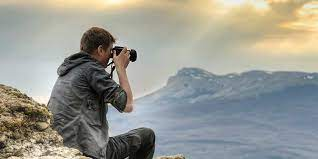

100%|██████████| 1/1 [00:10<00:00, 10.17s/it]



a man is holding a camera up to his head while looking at a mountain .


In [ ]:
pil_image = Image.open(UPLOADED_FILE)
display(pil_image)

image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    prefix = clip_model.encode_image(image)
    prefix_embed = model.clip_project(prefix.to(dtype=torch.float32)).reshape(1, prefix_length, -1)

generated_text_prefix = generate(model, tokenizer, embed=prefix_embed).split('.')[0].strip()+' .'

print('\n')
print(generated_text_prefix)